If any outputs fail to show please view them at this link: <a href="https://wlai0611.github.io/chem697presentation.html">https://wlai0611.github.io/chem697presentation.html</a>

You need to install openmm with: conda install -c conda-forge openmm

More info here: <a href="http://docs.openmm.org/latest/userguide/application/01_getting_started.html">OpenMM Docs</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
from IPython import display
import openmm
from openmm import *
from openmm.app import *
from openmm.unit import *
%matplotlib notebook
plt.rcParams['text.usetex'] = True
#plt.rcParams['animation.ffmpeg_path'] = 'C:\\FFmpeg\\bin\\ffmpeg.exe'
#plt.rcParams['animation.convert_path'] = 'C:\\Program Files\\ImageMagick-7.1.0-Q16-HDRI\\magick.exe'

<hr>
<a id="contents">
<h3>Table of Contents</h3>
<ol>
    <li><a href="#question">Research Question</a></li>
    <li><a href="#approach">Approach</a></li>
    <ul>
        <li><a href="#loss">Loss Function</a></li>
        <li><a href="#parameters">Parameters</a></li>
    </ul>
    <li><a href="#conclusion">Conclusion</a></li>
</ol>
<hr>

In class we learned how to use gradient descent to optimize the 2 parameters $m$ and $b$, for a loss function
$\ell = \Sigma (y_i-mx_i-b)^2$

In order to perform gradient descent we must find the partial derivative vector which is called "gradient": 
$\begin{bmatrix} \frac{\delta\ell}{\delta m} \\ \frac{\delta \ell}{\delta b} \end{bmatrix}$

The meaning of $\frac{\delta\ell}{\delta m}$ is: How much does the loss function increase if I increase the slope by 1, keeping intercept constant?

<a id="question"><h1>Research Question</h1><a href="#contents">Click Here to Return to Table of Contents</a>

But what if we were given a function that was not differentiable?  How do we find the gradient then?

In my research, I am investigating if the differences between speed limits and evolution speeds change based on the energy of the system.  Our approach is to examine the speed limits and evolutions speeds at the minimum energy configuration and other configurations.

Given any atom system, What is the positions of the atoms such that the energy of the system is minimum?

In my research, I used a method to approximate derivatives for functions that are not differentiable.  This method was called "finite differences".

In my research, I need to calculate the potential of a system fast.  My code is slow.  A Python library called OpenMM calculates potentials of systems fast.  But it is not differentiable.

Finite Differences Gradient Descent can help you if you have a function $f(m, b, \lambda, \sigma, \mu ...)$ of multiple parameters and that f is not differentiable.  But you still want to find the values of 
$m, b, \lambda,\sigma, \mu$ that make f small

<a id="approach">
<h1>Approach</h1>
<a href="#contents">Click Here to Return to Table of Contents</a>

Gradient Descent requires 2 inputs:
<ol>
    <li>The Loss Function</li>
    <li>The Initial Set of Starting Parameters</li>
</ol>

When the loss function is not differentiable, we must estimate the gradients by perturbations.  I got the idea to try this from this post: <a href="https://stats.stackexchange.com/questions/442074/using-finite-difference-to-estimate-high-dimensional-gradient-in-gradient-descen">Stack Exchange</a>

<a id="loss">
<h1>The Loss Function</h1>
<a href="#contents">Click Here to Return to Table of Contents</a>

In order to illustrate, how this finite differences gradient descent works, I minimized the a loss function 
$V=\Sigma\Sigma 4(\sqrt{\Delta x^2 + \Delta y^2}^{-12}-\sqrt{\Delta x^2 + \Delta y^2}^{-6})$

Where $\Delta x$ represents the horizontal distance between every pair of atoms

<IPython.core.display.Javascript object>


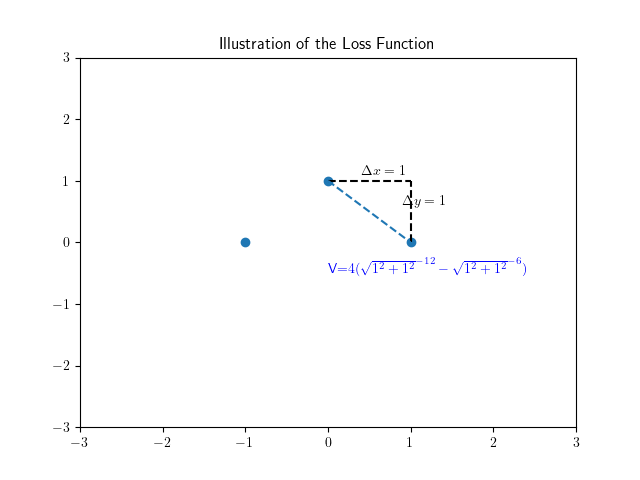

[Text(0.5, 1.0, 'Illustration of the Loss Function')]

In [2]:
fig,ax = plt.subplots()
positions = np.array([
    [1,0],
    [0,1],
    [-1,0]
])
ax.set(xlim=(-3,3),ylim=(-3,3))
ax.scatter(x=positions[:,0], y=positions[:,1])
ax.plot([0,1],[1,1],c='black',linestyle='--')
ax.text(x=0.4,y=1.10,s=r'$\Delta x=1$')
ax.plot([1,1],[0,1],c='black',linestyle='--')
ax.text(x=0.9,y=0.6,s=r'$\Delta y=1$')
ax.plot([0,1],[1,0],linestyle='--')
ax.text(x=0,y=-0.5,s=r'V=$4(\sqrt{1^2 + 1^2}^{-12}-\sqrt{1^2 + 1^2}^{-6})$',c='blue')
ax.set(title='Illustration of the Loss Function')

Below is the code that actually calculates this $V$ for a system of atoms.

In [3]:
def coordinates_to_potential_sum(coordinates, func = lambda r:4*(r**-12-r**-6)):
    potential_sum = 0
    coordinates = coordinates.reshape((len(coordinates)//2,2))

    for atom_i in range(len(coordinates)):
        per_dimension_distances = coordinates[atom_i,:] - coordinates
        interatomic_distances   = np.sqrt(np.sum(per_dimension_distances**2,axis=1))
        interatomic_distances[np.isclose(interatomic_distances,0)] = 1
        atom_i_potentials = func(interatomic_distances)
        potential_sum += atom_i_potentials.sum()

    return potential_sum/2 #its symmetric, we double counted

<a id="parameters">
<h1>The Starting Parameters</h1>
<a href="#contents">Click Here to Return to Table of Contents</a>

In a 3 atom system in 2D, there are 6 parameters: $x_A,y_A,x_B,y_B,x_C,y_C$ where $x_A$ represents the x coordinate of the atom A.

If we assume that $V$ is not differentiable, we can still approximate the gradient
$\begin{bmatrix} \frac{\delta V}{\delta x_A} \\ \frac{\delta V}{\delta y_A} \\
 \frac{\delta V}{\delta x_B} \\ \frac{\delta V}{\delta y_B} \\
  \frac{\delta V}{\delta x_C} \\ \frac{\delta V}{\delta y_C} \\
\end{bmatrix}$
by doing this procedure for each atom:
<ol>
    <li>increasing the $x_A$ by 1 and see how much the $V$ increases.  The increase in $V \approx 
    \frac{\delta V}{\delta x_A}$ </li>
    <li>increasing the $y_A$ by 1 and see how much the $V$ increases.  The increase in $V \approx 
    \frac{\delta V}{\delta y_A}$ </li>
    <li>update the atom x position by -1* $\frac{\delta V}{\delta x_A}$ and update atom y position by -1* $\frac{\delta V}{\delta y_A}$ </li>
</ol>

The animation below visually performs these 3 steps

<IPython.core.display.Javascript object>


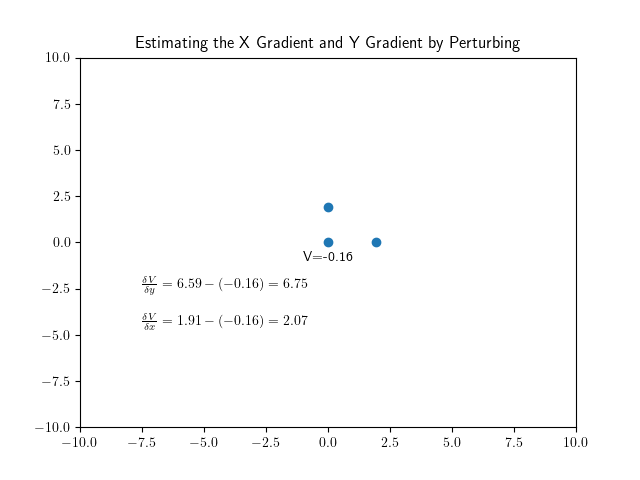

In [4]:

atoms = np.array([
    [[0,1.9],
     [0,0],
     [1.95,0]],
    [[0,1.9],
     [0,0],
     [1.95,0]],
    [[0,1.9],
     [0,1],
     [1.95,0]],
    [[0,1.9],
     [0,1],
     [1.95,0]],
    [[0,1.9],
     [0,0],
     [1.95,0]],
    [[0,1.9],
     [0,0],
     [1.95,0]],
     [[0,1.9],
     [1,0],
     [1.95,0]],
    [[0,1.9],
     [1,0],
     [1.95,0]],
])
fig, ax = plt.subplots()
frame0  = atoms[0]
trajectory = ax.scatter([],[])
ax.set(xlim=(-10,10),ylim=(-10,10))
label = ax.text(0,0,"")
x_gradient = ax.text(x=-7.5, y=-2.5, s=r"$\frac{\delta V}{\delta y} = 6.59 - (-0.16) = 6.75$",size=10)
y_gradient = ax.text(x=-7.5, y=-4.5, s=r"$\frac{\delta V}{\delta x} = 1.91 - (-0.16) = 2.07$",size=10)
ax.set(title='Estimating the X Gradient and Y Gradient by Perturbing')

def animate(frame_number):
    frame = atoms[frame_number]
    trajectory.set_offsets(frame)
    label.set_text(f"V={coordinates_to_potential_sum(frame.flatten()):.2f}")
    label.set_x(frame[1][0]-1)
    label.set_y(frame[1][1]-1)
    return trajectory, label
anim = anm.FuncAnimation(fig,func=animate,frames=len(atoms),interval=2000,blit=True)
plt.show()
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)

This is the function that performs those 3 steps animated above.

In [5]:
def get_gradients(func, parameters, perturb=0.0001):
    gradients = np.zeros(len(parameters))
    for param_number, parameter in enumerate(parameters):
        param_copy = parameters.copy()
        param_copy[param_number] += perturb
        forward_perturb          =  param_copy.copy()
        param_copy               =  parameters.copy()
        param_copy[param_number] -= perturb
        backward_perturb         =  param_copy.copy()
        gradients[param_number]  =  (func(forward_perturb) - func(backward_perturb))/(2*perturb)
    return gradients

After having obtained the gradient vector, we need to move the atom in the direction opposite of the gradient vector.  This is illustrated by the below diagram.

Here is an explanation by KhanAcademy explaining why the gradient vector is the direction of steepest ascent:<a href="https://www.youtube.com/watch?v=TEB2z7ZlRAw">YouTube Link</a>

<IPython.core.display.Javascript object>


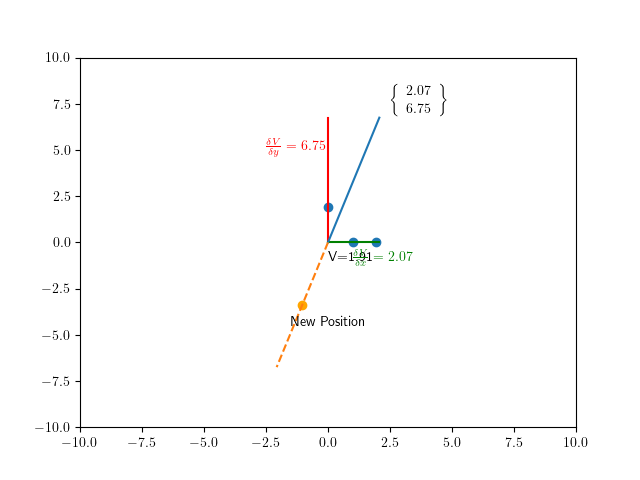

In [6]:

atoms = np.array([
    [[0,1.9],
     [0,0],
     [1.95,0]],
    [[0,1.9],
     [0,0],
     [1.95,0]],
    [[0,1.9],
     [0,1],
     [1.95,0]],
    [[0,1.9],
     [0,1],
     [1.95,0]],
    [[0,1.9],
     [0,0],
     [1.95,0]],
    [[0,1.9],
     [0,0],
     [1.95,0]],
     [[0,1.9],
     [1,0],
     [1.95,0]],
    [[0,1.9],
     [1,0],
     [1.95,0]],
])
fig, ax = plt.subplots()
frame0  = atoms[0]
trajectory = ax.scatter(frame0[:,0],frame0[:,1])
ax.set(xlim=(-10,10),ylim=(-10,10))
label = ax.text(0,0,"")
x_gradient = ax.text(x=-2.5, y=5, s=r"$\frac{\delta V}{\delta y} =  6.75$",c='r',size=10)
y_gradient = ax.text(x=1, y=-1, s=r"$\frac{\delta V}{\delta x} =  2.07$",c='g',size=10)
gradient_vector = ax.text(x=2.5,y=7.5,s=r'$\left\{\begin{array}{c} 2.07 \\ 6.75 \end{array}\right\}$',size=10)
new_position = ax.text(x=-1.5, y = -4.5, s='New Position')

ax.plot([0,0],[0,6.75],label=r'$\frac{\delta V}{\delta y}$',c='r')
ax.plot([0,2.07],[0,0],label=r'$\frac{\delta V}{\delta y}$',c='g')
ax.plot([0,2.07],[0,6.75],)

ax.plot([0,-2.07],[0,-6.75],linestyle='--')
ax.scatter(-1.035,-3.375,c='orange')
plt.show()

We need to perform this position-update many times.  Below is the code that does whats in the diagram above in a loop.

In [7]:
def gradient_descent(func, starting_params, max_iter=100, step_len=0.1, tolerance=3):
    fx      = func(starting_params)
    counter = 0
    params  = starting_params.copy()
    steps   = []
    steps.append(starting_params)
    fxs     = []
    fxs.append(fx)
    while abs(fx) > tolerance and counter < max_iter:
        gradients            = get_gradients(func, params)
        normalized_gradients = gradients/np.sqrt(np.sum(gradients**2))
        step_direction = normalized_gradients
        step_vector    = step_len * step_direction
        params         = params - step_vector
        fx = func(params)
        steps.append(params)
        fxs.append(fx)
        counter += 1

    return steps, fxs

Below, I use the 3 functions defined to find the optimal $x_A,y_A,x_B,y_B,x_C,y_C$ such that the $V$ is minimum

<IPython.core.display.Javascript object>


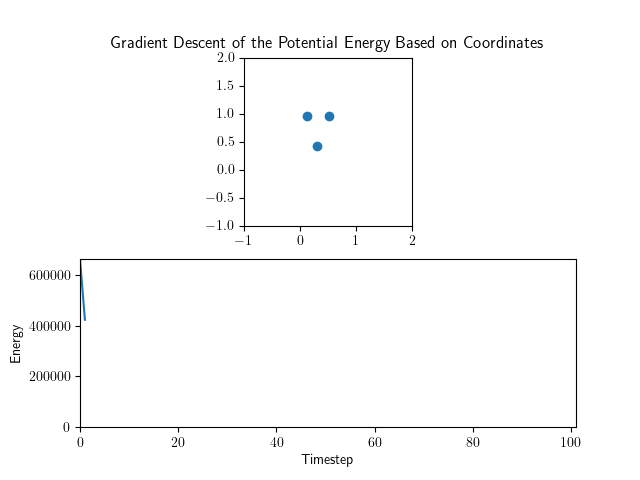

In [8]:
rng             = np.random.default_rng(seed=1)
starting_params = rng.random(6)
steps, fxs = gradient_descent(coordinates_to_potential_sum, 
                              starting_params, 
                              step_len=0.01, 
                              max_iter=100, 
                              tolerance=0.01)
steps = np.array(steps)
nsteps, nparams = steps.shape
steps = steps.reshape(nsteps, nparams//2, 2)
fig, ax = plt.subplots(nrows=2)
ax[0].set(xlim=(-1,2),ylim=(-1,2), title='Gradient Descent of the Potential Energy Based on Coordinates')
ax[0].set_aspect('equal')
atoms = ax[0].scatter(steps[0,:,0], steps[0,:,1])
ax[1].set(xlim=(0,len(fxs)), ylim=(0,max(fxs)))
energies, = ax[1].plot([],[])
ax[1].set(xlabel='Timestep',ylabel='Energy')

def animate(i):
    current_step = steps[i]
    atoms.set_offsets(current_step[:,:2])
    energies.set_data(np.arange(i),fxs[:i])
    return atoms, energies

anim = anm.FuncAnimation(fig, animate, frames = len(steps), blit=True)
#anim.save('faster_gradient_descent_lj.gif',writer='imagemagick')
plt.show()
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)



In my 2D, example, $V$ was actually differentiable so there is no real benefit to using finite differences in that scenario.  Finit differences is made for situations in which your function is not differentiable.

OpenMM is package in Python that calculates the interatomic potential between every pair of atoms in your system.  It is useful because it can work for many different types of chemical systems.

Because it works for so many systems it must use a complex algorithm to calculate $V$ similar to how I did above.

But because their $V$ algorithm is so complex it is also <b>non-differentiable</b>.  So if we wanted to minimize the OpenMM Potential with gradient descent, we must use a version of gradient descent that is made for non-differentiable systems.

Below I use finite differences to minimize the potential for the OpenMM's  non-differentiable $V$ function

In [9]:
class SimulationHelper():
    def __init__(self, natoms):
        self.natoms = natoms
        self.set_atoms(element="argon", atomic_number=18, mass=1*amu)
        self.set_forces(sigma= 1*nanometer, epsilon=1*kilocalories_per_mole)
        self.simulation = Simulation(     self.topology, self.system,
                                      LangevinIntegrator(293.15*kelvin,1/picosecond,2*femtoseconds))
        
    def set_atoms(self, element, atomic_number, mass):
        self.system = System()
        self.topology = Topology()
        chain  = self.topology.addChain()
        residue= self.topology.addResidue(element,chain)
        element_object = Element.getByAtomicNumber(atomic_number)

        for atom_index in range(self.natoms):
            self.system.addParticle(mass)
            self.topology.addAtom(element, element_object,residue)
    
    def set_forces(self, sigma, epsilon, charge=0.0):
        self.force = openmm.NonbondedForce()
        for atom_index in range(self.natoms):
            self.force.addParticle(charge, sigma, epsilon)
        self.system.addForce(self.force)

    def potential_function(self, coordinates):
        self.simulation.context.setPositions(coordinates*nanometer)
        state = self.simulation.context.getState(getEnergy=True)
        energy= state.getPotentialEnergy()/kilocalories_per_mole
        return energy


<IPython.core.display.Javascript object>


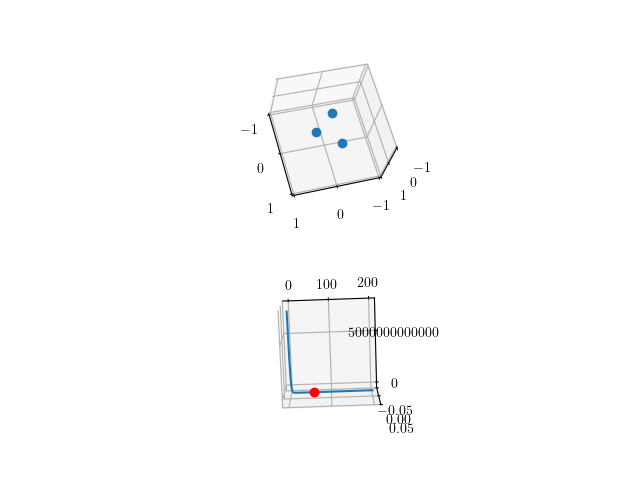

In [10]:
simulator = SimulationHelper(natoms=3)

starting_params = np.array([
    [0,0.01,0],
    [-0.1,0,0],
    [0.1,0,0]
]).flatten()


def potential_wrapper(coordinates):
    return simulator.potential_function(coordinates.reshape((len(coordinates)//3,3)))
    

steps, fxs = gradient_descent(potential_wrapper, starting_params, step_len=0.01, max_iter=200, tolerance=0.01)
steps = np.array(steps)
nsteps, nparams = steps.shape
steps = steps.reshape(nsteps, nparams//3, 3)

#https://stackoverflow.com/questions/41602588/how-to-create-3d-scatter-animations
fig, axes = plt.subplots(nrows=2, ncols=1, subplot_kw=dict(projection="3d"))
plt.subplots_adjust(wspace=0.5,hspace=0.5)
axes[0].view_init(elev=-119, azim=-146, roll=-20)
axes[0].set(xlim=(-1,1), ylim=(-1,1), zlim=(-1,1))
atoms, = axes[0].plot(*steps[0].T,linestyle='',marker='o')
energies, = axes[1].plot(range(len(steps)), fxs, 0)
time_marker, = axes[1].plot(xs=0, ys=fxs[0], zs=0, c='red',linestyle='',marker='o')
axes[1].ticklabel_format(axis='y',style='plain')
axes[1].view_init(elev=101,azim=-92, roll=0)

def animate(frame_number):
    coordinates = steps[frame_number]
    atoms.set_data(coordinates[:,0], coordinates[:,1])
    atoms.set_3d_properties(coordinates[:,2])
    time_marker.set_data([frame_number], [fxs[frame_number]])
    time_marker.set_3d_properties([0])
    return atoms, time_marker

anim = anm.FuncAnimation(fig, animate, len(steps), blit=True)
plt.show()
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)

<a id="conclusion">
<h1>Conclusion</h1>
<a href="#contents">Click Here to Return to Table of Contents</a>

The position that minimizes the energy of the system is the equilateral triangle configuration and the 3D example above clearly shows a point at which the atoms get stuck in an equilateral triangle shape and the potential energy is at a minimum.

We can also see that the potential energy drops very sharply once the atoms get a sufficient distance from each other. The elbow point of the potential energy plot occurs while the atoms are in a linear configuration which is surprising because the linear configuration should have the highest potential energy.